In [1]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
from scipy import stats
import scienceplots

plt.style.use('science')

FOLDER = "20250427"
ASSETS = "../assets/"+FOLDER+"/"
INPUT = "../input/"+FOLDER+"/"
OUTPUT = "../output/"+FOLDER+"/"

LINE_COLOR='#1B4244'
LINE_COLOR_RED='#FB4142'
LINE_COLOR_BLUE='#3F86BC'

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Download the webpage
url = 'https://inflationdata.com/Inflation/Consumer_Price_Index/HistoricalCPI.aspx'
response = requests.get(url)

# Parse HTML 
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table with CPI data
table = soup.find('table')

# 2) Let pandas read any tables found in that HTML snippet
dfs = pd.read_html(table.prettify())

# In this snippet, the table of interest should be the first one:
df = dfs[0]

# 3) The columns should be: [Year, Jan, Feb, Mar, ..., Dec, Ave.]
#    but let’s verify/rename them for clarity. 
#    (If read_html picks up the header row correctly, you can skip rename)

df.columns = [
    "Year","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","Ave."
]

# 4) Drop the "Ave." column, since it’s an annual average (not monthly)
df = df.drop(columns=["Ave."])

# 5) Reshape from wide to long format: each row = (Year, MonthName, Value)
df_long = df.melt(
    id_vars="Year",         # Keep the "Year" column as identifier
    var_name="MonthName",   # Name for the melted column (Jan, Feb, Mar, etc.)
    value_name="Value"      # Name for the CPI value
)

# 6) Map month names to month numbers so we can build a date
month_map = {
    "Jan": 1, "Feb": 2, "Mar": 3,
    "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9,
    "Oct": 10,"Nov": 11,"Dec": 12
}
df_long["Month"] = df_long["MonthName"].map(month_map)

# 7) Create a proper datetime column (assume "Day=1")
df_long["Date"] = pd.to_datetime(
    df_long["Year"].astype(str) + "-" +
    df_long["Month"].astype(str) + "-01"
)

# 8) Convert the “Value” text to numeric (coerce blanks or &nbsp; → NaN)
df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")

# 9) Drop rows that have NaN in Value (future months or blanks)
df_long = df_long.dropna(subset=["Value"])

# 10) Sort chronologically and set Date as the index
df_long = df_long.sort_values("Date").set_index("Date")

# 11) If you only want the monthly CPI column (and not Year, MonthName, Month):
df_final = df_long[["Value"]].rename(columns={"Value":"CPI"})

# df_final now has a Date index (monthly) and one column “CPI”
df_final.to_csv(INPUT+"cpi.csv")

C:\Users\pkapl\AppData\Local\Temp\ipykernel_26212\394455391.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(table.prettify())


In [3]:
# prompt: download all pages (max 5000 per page from this api) https://api.eia.gov/v2/electricity/retail-sales/data/?frequency=monthly&data[0]=price&facets[sectorid][]=COM&facets[sectorid][]=IND&start=2009-01&offset=0&length=100&api_key=eLo7fkC9HFI6ThInSbQsD2mrVcw2yiSrZBYGQaP9


def download_all_pages(api_url, max_pages=100000, page_size=4000):
    all_data = []
    offset = 0
    page_number = 0

    while True:
      page_number += 1
      url = f"{api_url}&offset={offset}&length={page_size}"
      print(f"Downloading page {page_number}: {url}")

      try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        data = response.json()
        
        if not data.get('response', {}).get('data'): #Handle empty responses
            break

        all_data.extend(data['response']['data'])
        offset += page_size

        if page_number >= max_pages or len(data['response']['data']) < page_size :
            break # Stop when exceeding the max pages or when a page contains fewer elements than the requested length

      except requests.exceptions.RequestException as e:
        print(f"Error downloading page {page_number}: {e}")
        break # Stop on errors

    return all_data


api_url = "https://api.eia.gov/v2/electricity/retail-sales/data/?frequency=monthly&data[0]=price&facets[sectorid][]=COM&facets[sectorid][]=IND&start=2001-01&api_key=eLo7fkC9HFI6ThInSbQsD2mrVcw2yiSrZBYGQaP9"
all_data = download_all_pages(api_url)

#Convert the data to a DataFrame
df = pd.DataFrame(all_data)
df.to_csv(INPUT+"electricity_data.csv", index=False)

#Print or save the DataFrame as you require
print(df.head()) # Print the first 5 rows to inspect the data
#df.to_csv('electricity_data.csv', index=False) # Uncomment to save as a csv file


    period stateid stateDescription sectorid  sectorName  price  \
0  2020-09      WI        Wisconsin      IND  industrial   7.45   
1  2020-09      WY          Wyoming      COM  commercial  10.07   
2  2020-09      WY          Wyoming      IND  industrial    7.1   
3  2020-09     NEW      New England      COM  commercial  15.72   
4  2020-09     NEW      New England      IND  industrial  12.81   

               price-units  
0  cents per kilowatt-hour  
1  cents per kilowatt-hour  
2  cents per kilowatt-hour  
3  cents per kilowatt-hour  
4  cents per kilowatt-hour  


In [4]:
df.set_index('period', inplace=True)
df.index = pd.to_datetime(df.index)
df

,stateid,stateDescription,sectorid,sectorName,price,price-units
period,,,,,,
2020-09-01,WI,Wisconsin,IND,industrial,7.45,cents per kilowatt-hour
2020-09-01,WY,Wyoming,COM,commercial,10.07,cents per kilowatt-hour
2020-09-01,WY,Wyoming,IND,industrial,7.1,cents per kilowatt-hour
2020-09-01,NEW,New England,COM,commercial,15.72,cents per kilowatt-hour
2020-09-01,NEW,New England,IND,industrial,12.81,cents per kilowatt-hour
...,...,...,...,...,...,...
2016-07-01,CO,Colorado,IND,industrial,7.7,cents per kilowatt-hour
2016-07-01,CT,Connecticut,COM,commercial,15.57,cents per kilowatt-hour
2016-07-01,CT,Connecticut,IND,industrial,12.87,cents per kilowatt-hour


In [5]:
df.sort_index(inplace=True)
df

,stateid,stateDescription,sectorid,sectorName,price,price-units
period,,,,,,
2001-01-01,MI,Michigan,COM,commercial,7.48,cents per kilowatt-hour
2001-01-01,MTN,Mountain,COM,commercial,5.9,cents per kilowatt-hour
2001-01-01,MTN,Mountain,IND,industrial,4.18,cents per kilowatt-hour
2001-01-01,PACC,Pacific Contiguous,COM,commercial,7.92,cents per kilowatt-hour
2001-01-01,PACC,Pacific Contiguous,IND,industrial,5.16,cents per kilowatt-hour
...,...,...,...,...,...,...
2025-02-01,WSC,West South Central,IND,industrial,5.94,cents per kilowatt-hour
2025-02-01,MTN,Mountain,COM,commercial,10.75,cents per kilowatt-hour
2025-02-01,MTN,Mountain,IND,industrial,7.54,cents per kilowatt-hour


In [6]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [7]:
mean_price_by_sector_month = df.groupby(['sectorid', pd.Grouper(freq='MS')])['price'].mean().unstack().T
mean_price_by_sector_month

sectorid,COM,IND
period,,
2001-01-01,7.199355,5.251129
2001-02-01,7.401774,5.331935
2001-03-01,7.530000,5.390484
2001-04-01,7.591613,5.404355
2001-05-01,7.684032,5.440161
...,...,...
2024-10-01,13.733387,10.012419
2024-11-01,13.422258,9.823065
2024-12-01,13.586452,9.943387


In [8]:
# Read CPI.xlsx file into a dataframe
cpi_df = pd.read_csv(INPUT+'cpi.csv')
# Convert the 'Date' column to datetime
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])

# Set Date as index
cpi_df.set_index('Date', inplace=True)

# Sort the index to ensure chronological order
cpi_df.sort_index(inplace=True)

In [9]:
# Merge cpi_df with mean_price_by_sector_month on index (date)
mean_price_by_sector_month = mean_price_by_sector_month.join(cpi_df)


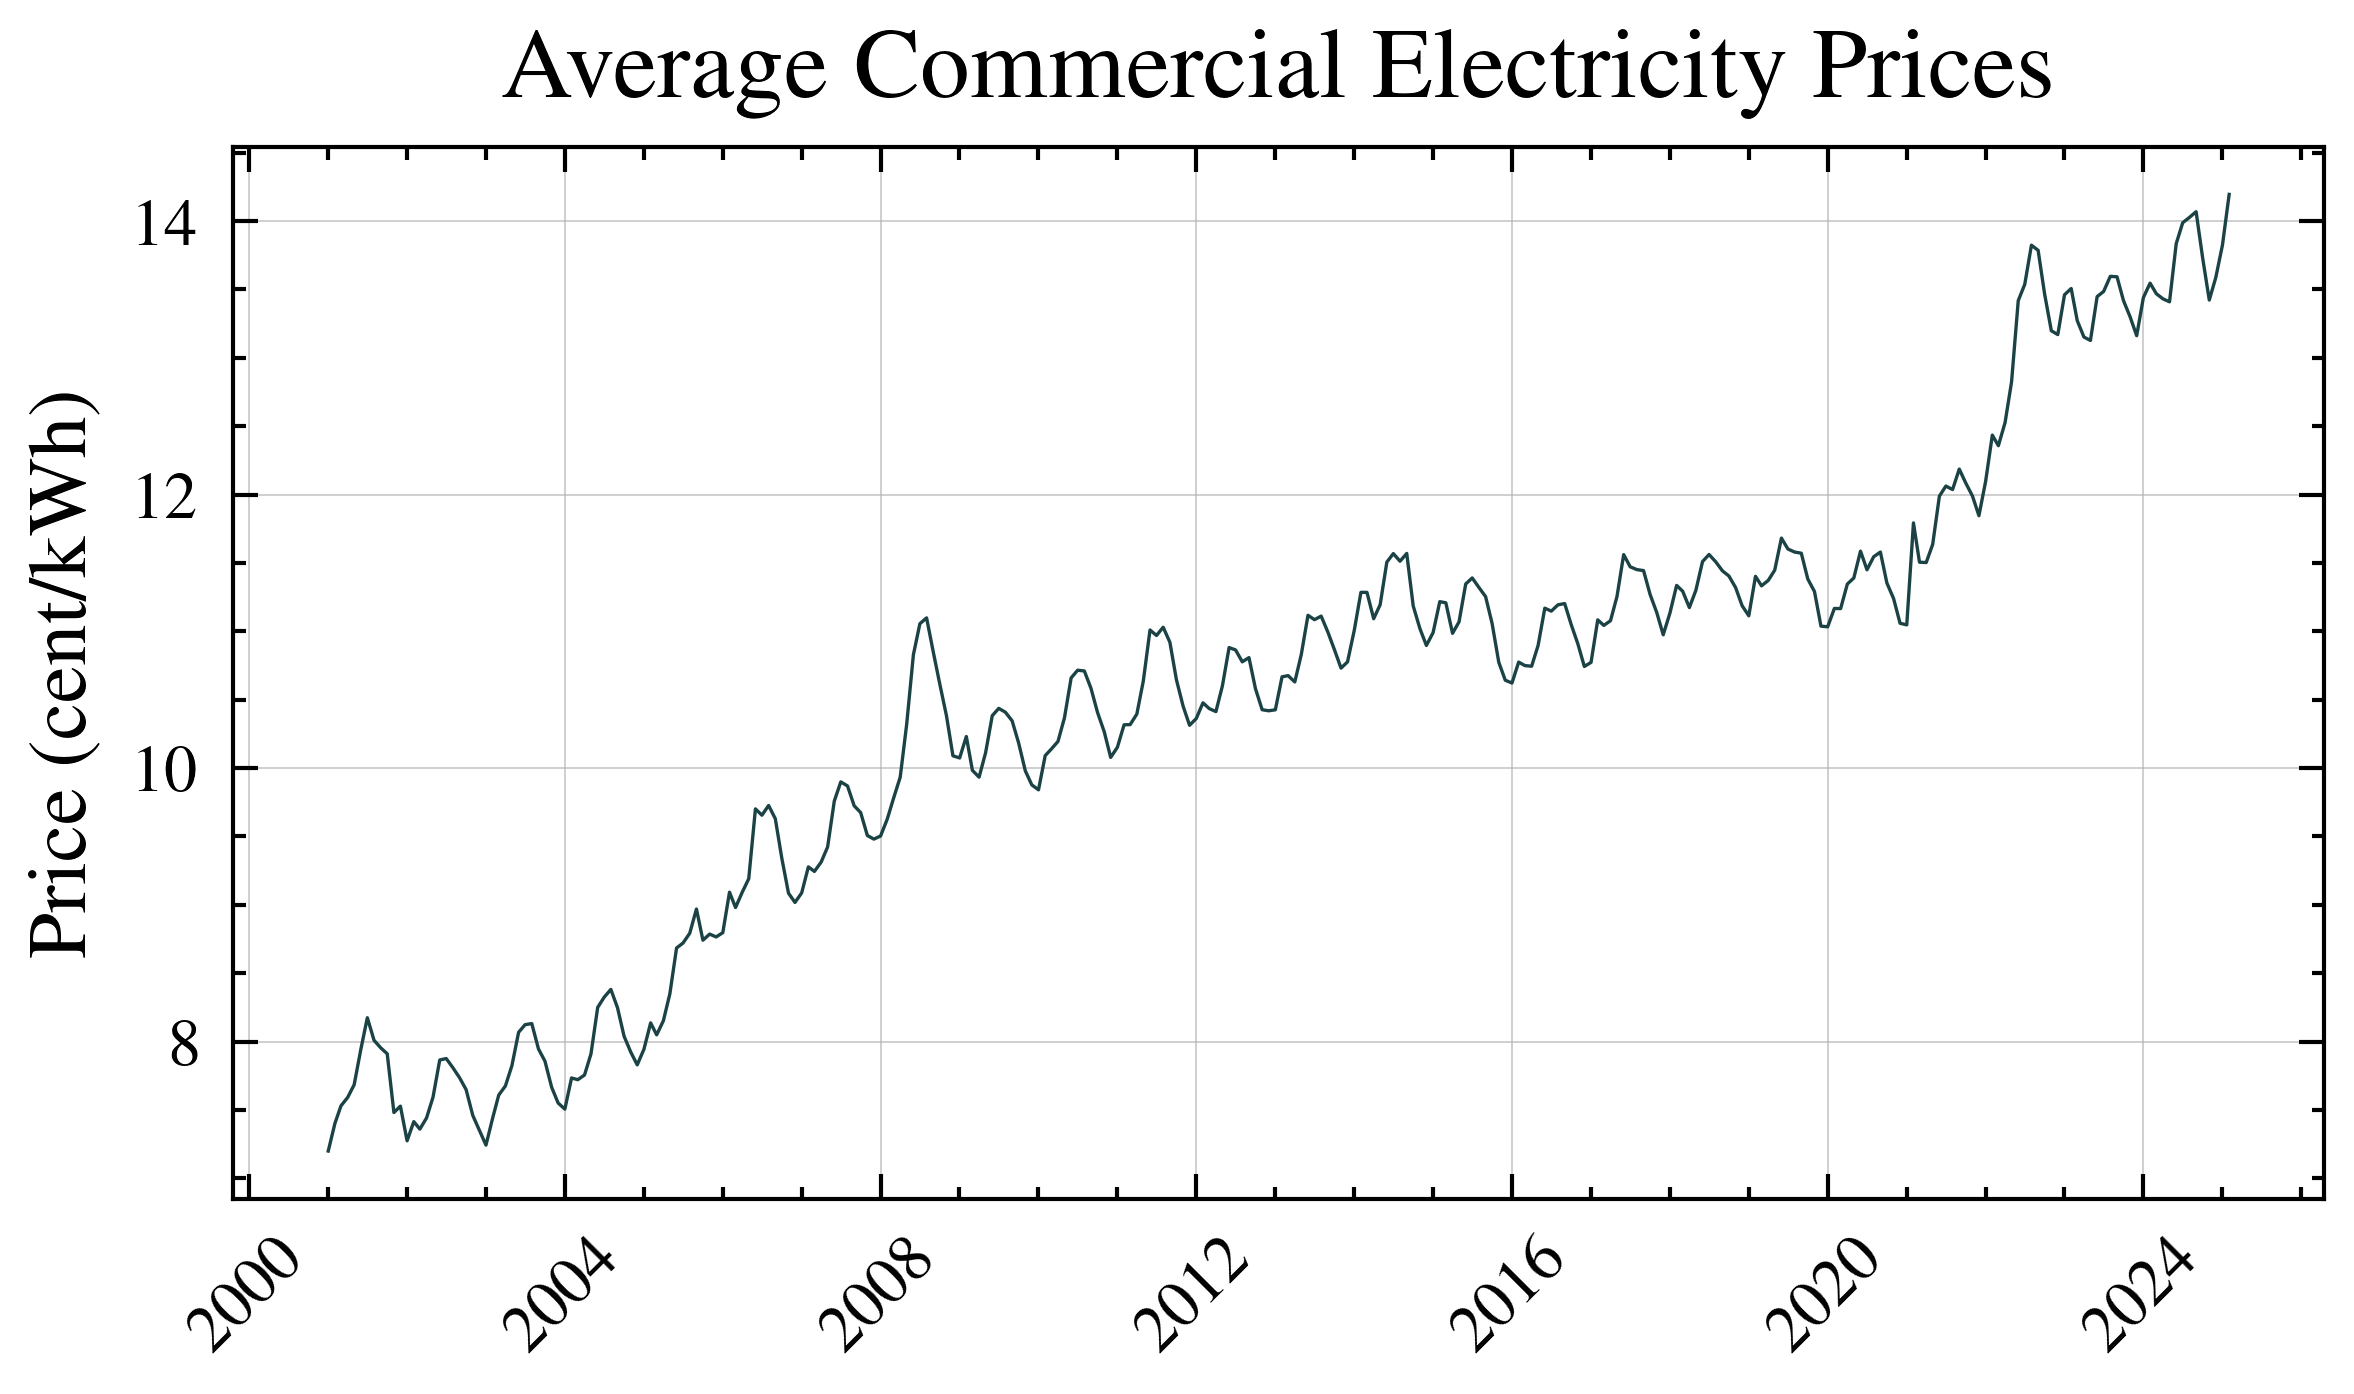

In [10]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.plot(mean_price_by_sector_month.index, mean_price_by_sector_month['COM'],  label='Commercial', linewidth=0.4, color=LINE_COLOR)
#    plt.plot(mean_price_by_sector_month.index, mean_price_by_sector_month['IND'], label='Industrial')

    plt.title('Average Commercial Electricity Prices', fontsize=12)
    plt.ylabel('Price (cent/kWh)', fontsize=10)
    plt.savefig(ASSETS+'electricityprices1.png')
    plt.show()

In [11]:
mean_price_by_sector_month['COM_CPI'] = mean_price_by_sector_month['COM'] / mean_price_by_sector_month['CPI']
mean_price_by_sector_month['IND_CPI'] = mean_price_by_sector_month['IND'] / mean_price_by_sector_month['CPI']

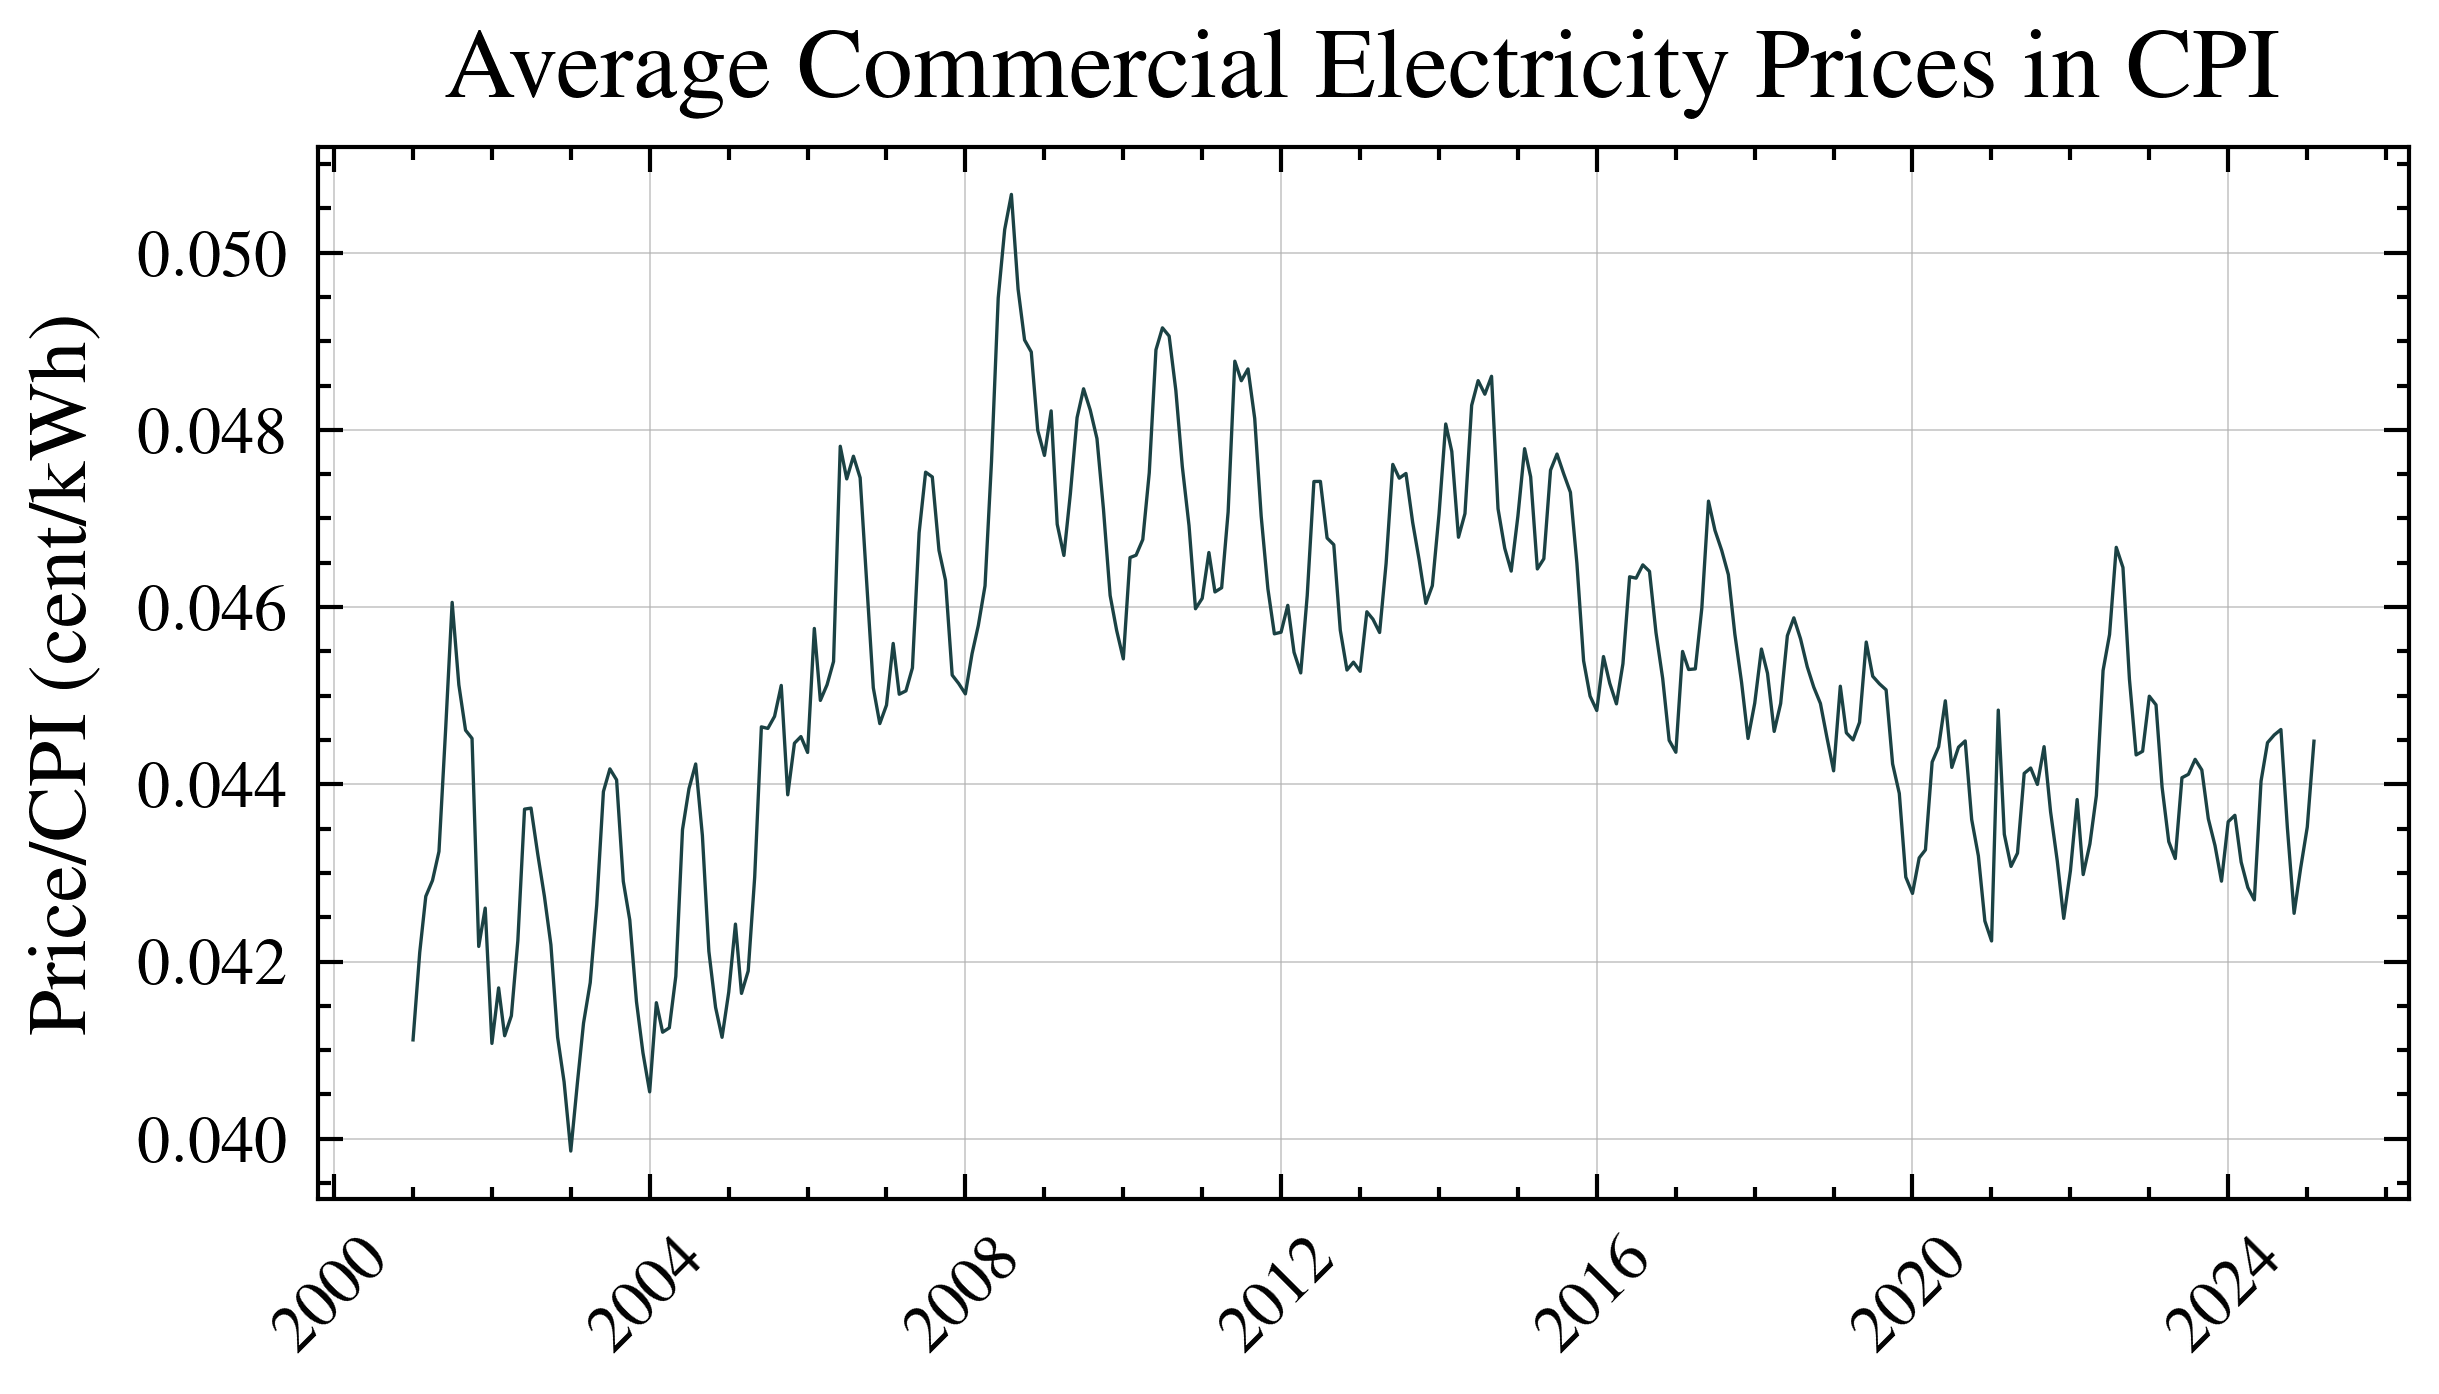

In [12]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.plot(mean_price_by_sector_month.index, mean_price_by_sector_month['COM_CPI'],  label='Commercial', linewidth=0.4, color=LINE_COLOR)
#    plt.plot(mean_price_by_sector_month.index, mean_price_by_sector_month['IND'], label='Industrial')

    plt.title('Average Commercial Electricity Prices in CPI', fontsize=12)
    plt.ylabel('Price/CPI (cent/kWh)', fontsize=10)
    plt.savefig(ASSETS+'electricityprices2.png')
    plt.show()

In [13]:
from prophet import Prophet

# Prepare data for Prophet (requires 'ds' and 'y' columns)
# Create separate dataframes for COM and IND
com_df = pd.DataFrame({
    'ds': mean_price_by_sector_month.index,
    'y': mean_price_by_sector_month['COM_CPI']
}).reset_index(drop=True)

ind_df = pd.DataFrame({
    'ds': mean_price_by_sector_month.index,
    'y': mean_price_by_sector_month['IND_CPI']
}).reset_index(drop=True)

# Create and fit Prophet models
m_com = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m_com.fit(com_df)

m_ind = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m_ind.fit(ind_df)

# Create future dates dataframe
future_dates = m_com.make_future_dataframe(periods=120*12, freq='MS')  # 120 years into future (2025-2145)

# Make predictions
forecast_com = m_com.predict(future_dates)
forecast_ind = m_ind.predict(future_dates)

# Plot the forecasts
plt.figure(figsize=(15, 8))
plt.plot(com_df['ds'], com_df['y'], 'b-', label='Historical COM')
plt.plot(ind_df['ds'], ind_df['y'], 'r-', label='Historical IND')
plt.plot(forecast_com['ds'], forecast_com['yhat'], 'b--', label='Forecast COM')
plt.plot(forecast_ind['ds'], forecast_ind['yhat'], 'r--', label='Forecast IND')

plt.fill_between(forecast_com['ds'], 
                 forecast_com['yhat_lower'], 
                 forecast_com['yhat_upper'], 
                 color='blue', alpha=0.1)
plt.fill_between(forecast_ind['ds'], 
                 forecast_ind['yhat_lower'], 
                 forecast_ind['yhat_upper'], 
                 color='red', alpha=0.1)

plt.title('Electricity Price Forecast by Sector (2009-2035)')
plt.xlabel('Year')
plt.ylabel('Cents per kilowatt-hour')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

23:22:55 - cmdstanpy - INFO - Chain [1] start processing
23:22:55 - cmdstanpy - INFO - Chain [1] done processing
23:22:55 - cmdstanpy - INFO - Chain [1] start processing
23:22:55 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
cpi_2020 = cpi_df['1980':'2000'].copy()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cpi_2020.index.astype('int64'), cpi_2020['CPI'])

# Create the regression line
regression_line = slope * cpi_2020.index.astype('int64') + intercept

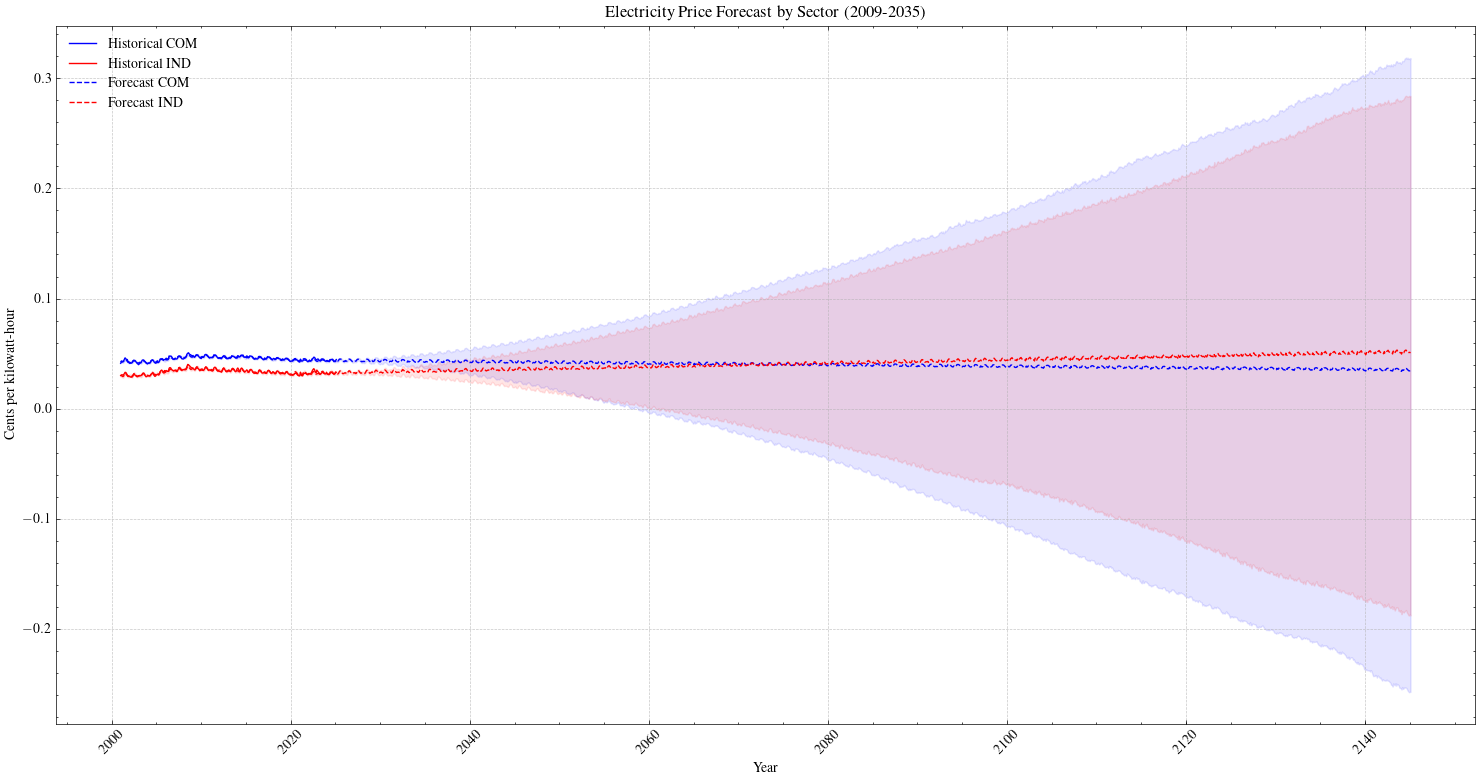

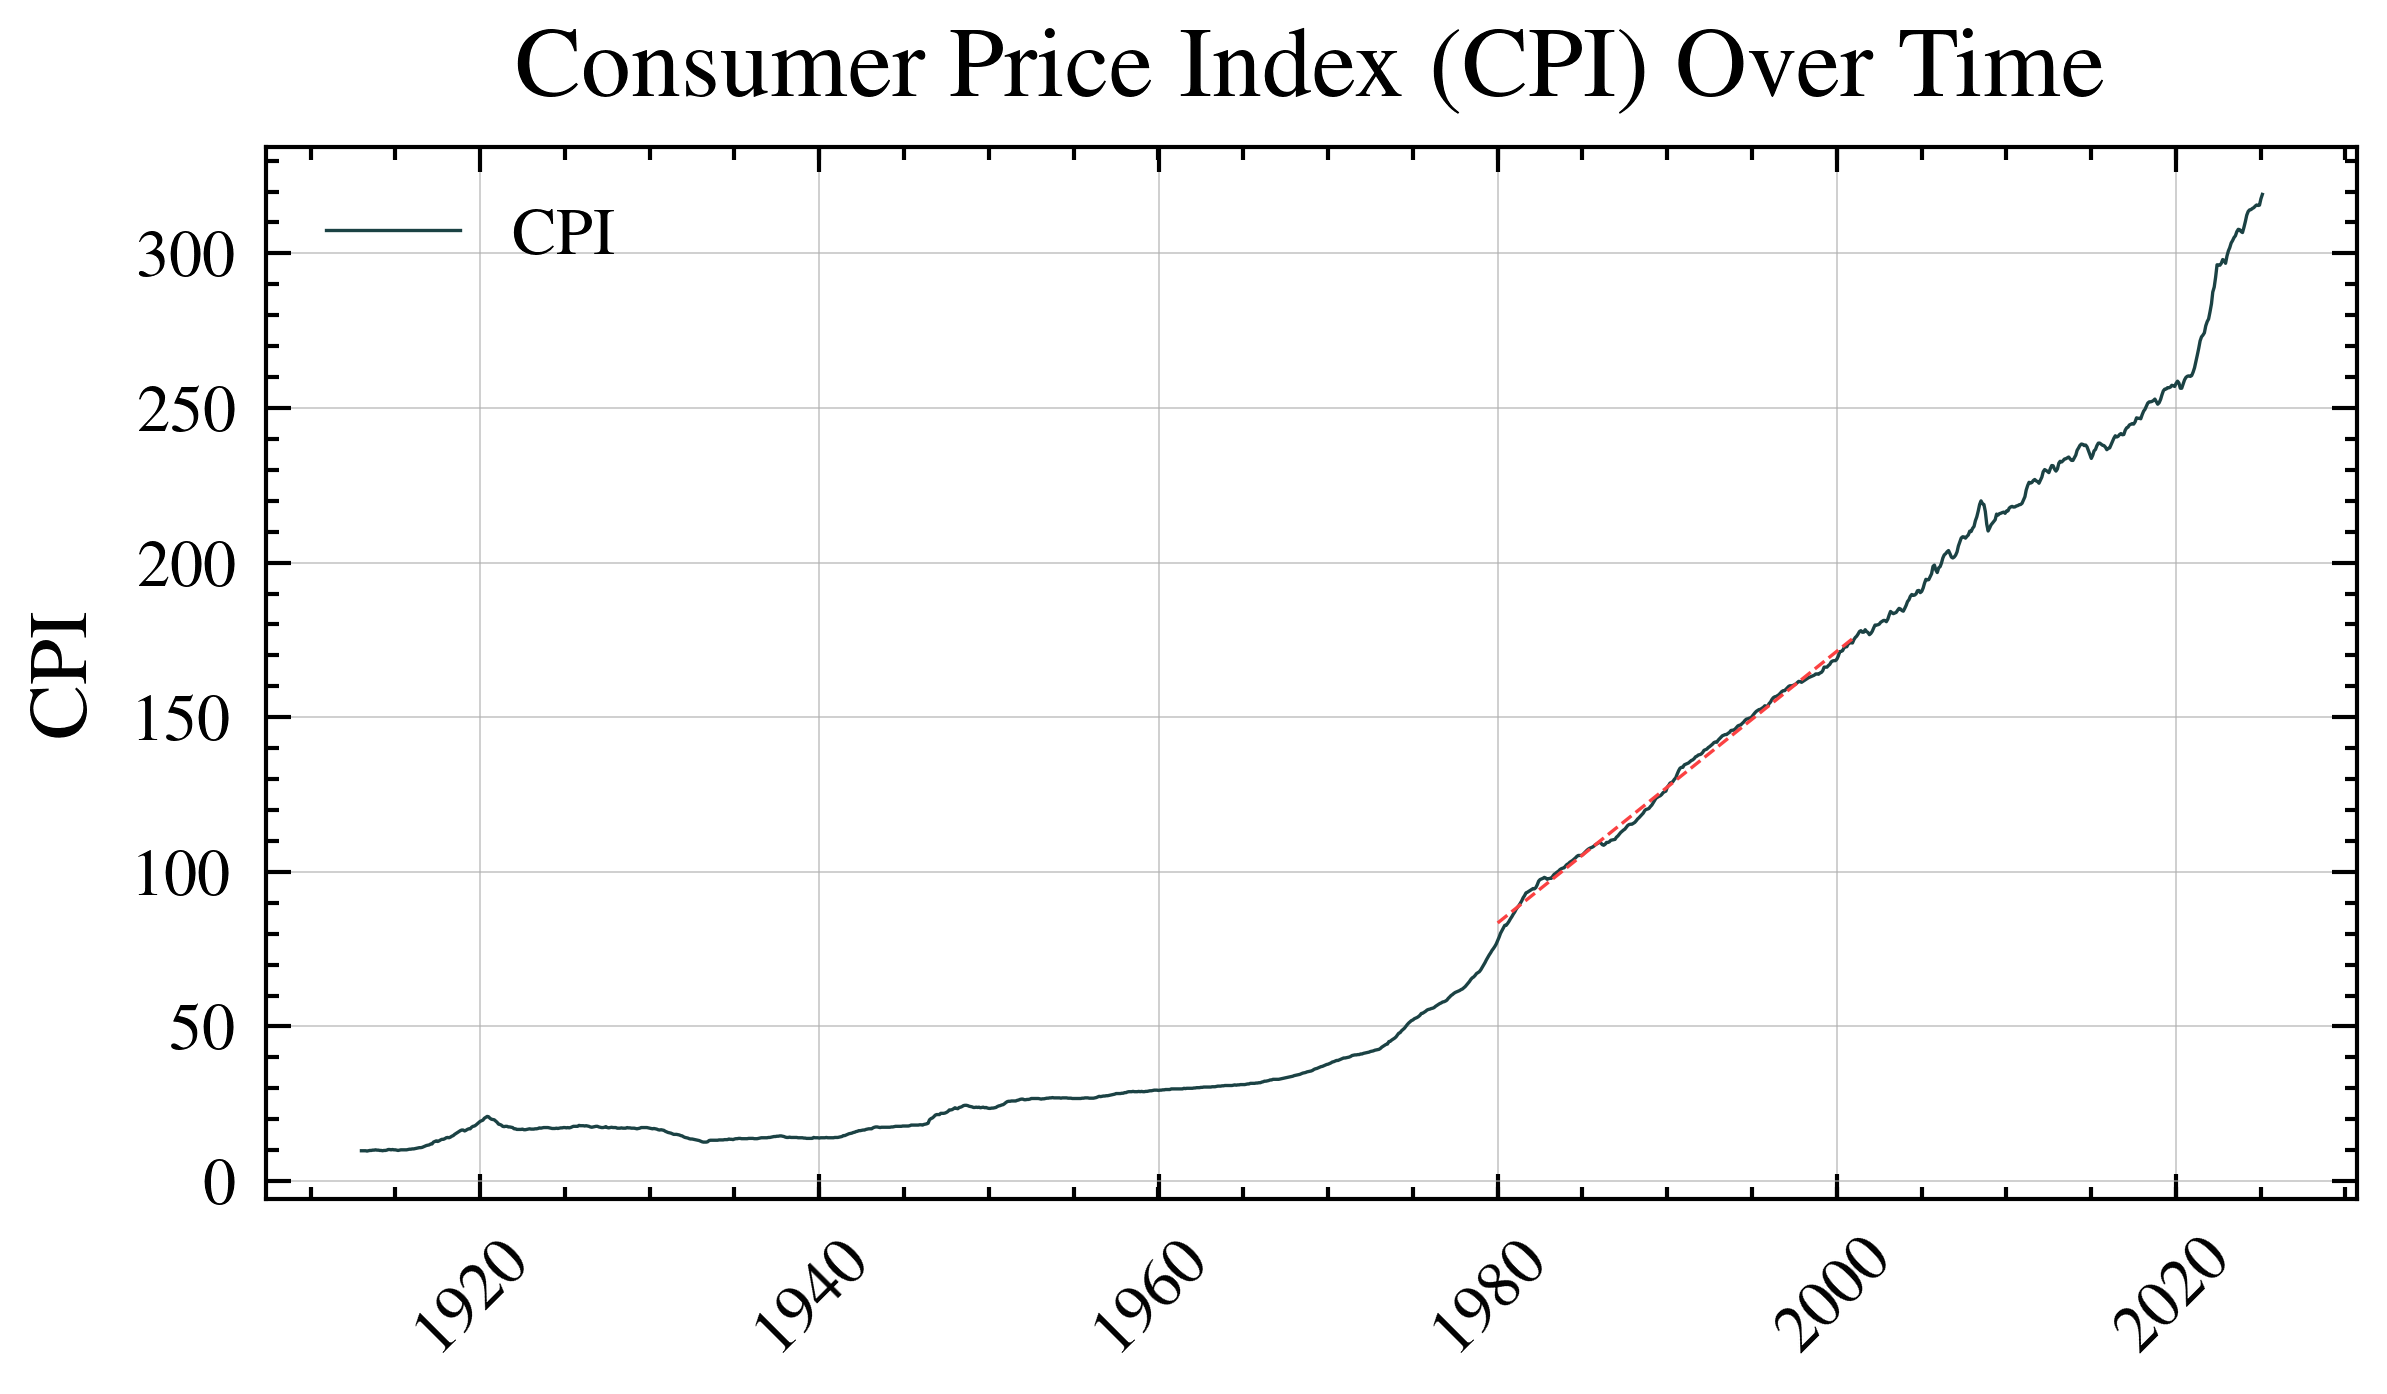

In [15]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(cpi_df[:df.index[-1]].index, cpi_df[:df.index[-1]]['CPI'], linewidth=0.4, linestyle='-', color=LINE_COLOR, label='CPI')
    plt.plot(cpi_2020.index, regression_line, linewidth=0.4, linestyle='--', color=LINE_COLOR_RED)
    plt.ylabel('CPI', fontsize=10)
    plt.title('Consumer Price Index (CPI) Over Time', fontsize=12)
    plt.legend()
    plt.savefig(ASSETS+'cpi2.png')
    plt.show()    

In [16]:
# Create a new date index from 2026 to 2145 yearly
new_date_idx = pd.date_range(start=cpi_df.index[-1], end='2145-01-01', freq='MS')

# Create a new DataFrame for the forecast
new_cpi_forecast = pd.DataFrame(index=new_date_idx)

# Calculate the forecasted InverseSqrtEfficiency using the linear regression equation
new_cpi_forecast['CPI'] = slope * (new_cpi_forecast.index.astype('int64') - cpi_df.index.astype('int64')[-1]) + cpi_df['CPI'][-1]

new_cpi_forecast

C:\Users\pkapl\AppData\Local\Temp\ipykernel_26212\3419245318.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_cpi_forecast['CPI'] = slope * (new_cpi_forecast.index.astype('int64') - cpi_df.index.astype('int64')[-1]) + cpi_df['CPI'][-1]


,CPI
2025-03-01,319.799000
2025-04-01,320.171890
2025-05-01,320.532751
2025-06-01,320.905641
2025-07-01,321.266502
...,...
2144-09-01,844.827886
2144-10-01,845.188747
2144-11-01,845.561637
2144-12-01,845.922498


In [17]:
cpi_df = pd.concat([cpi_df, new_cpi_forecast])

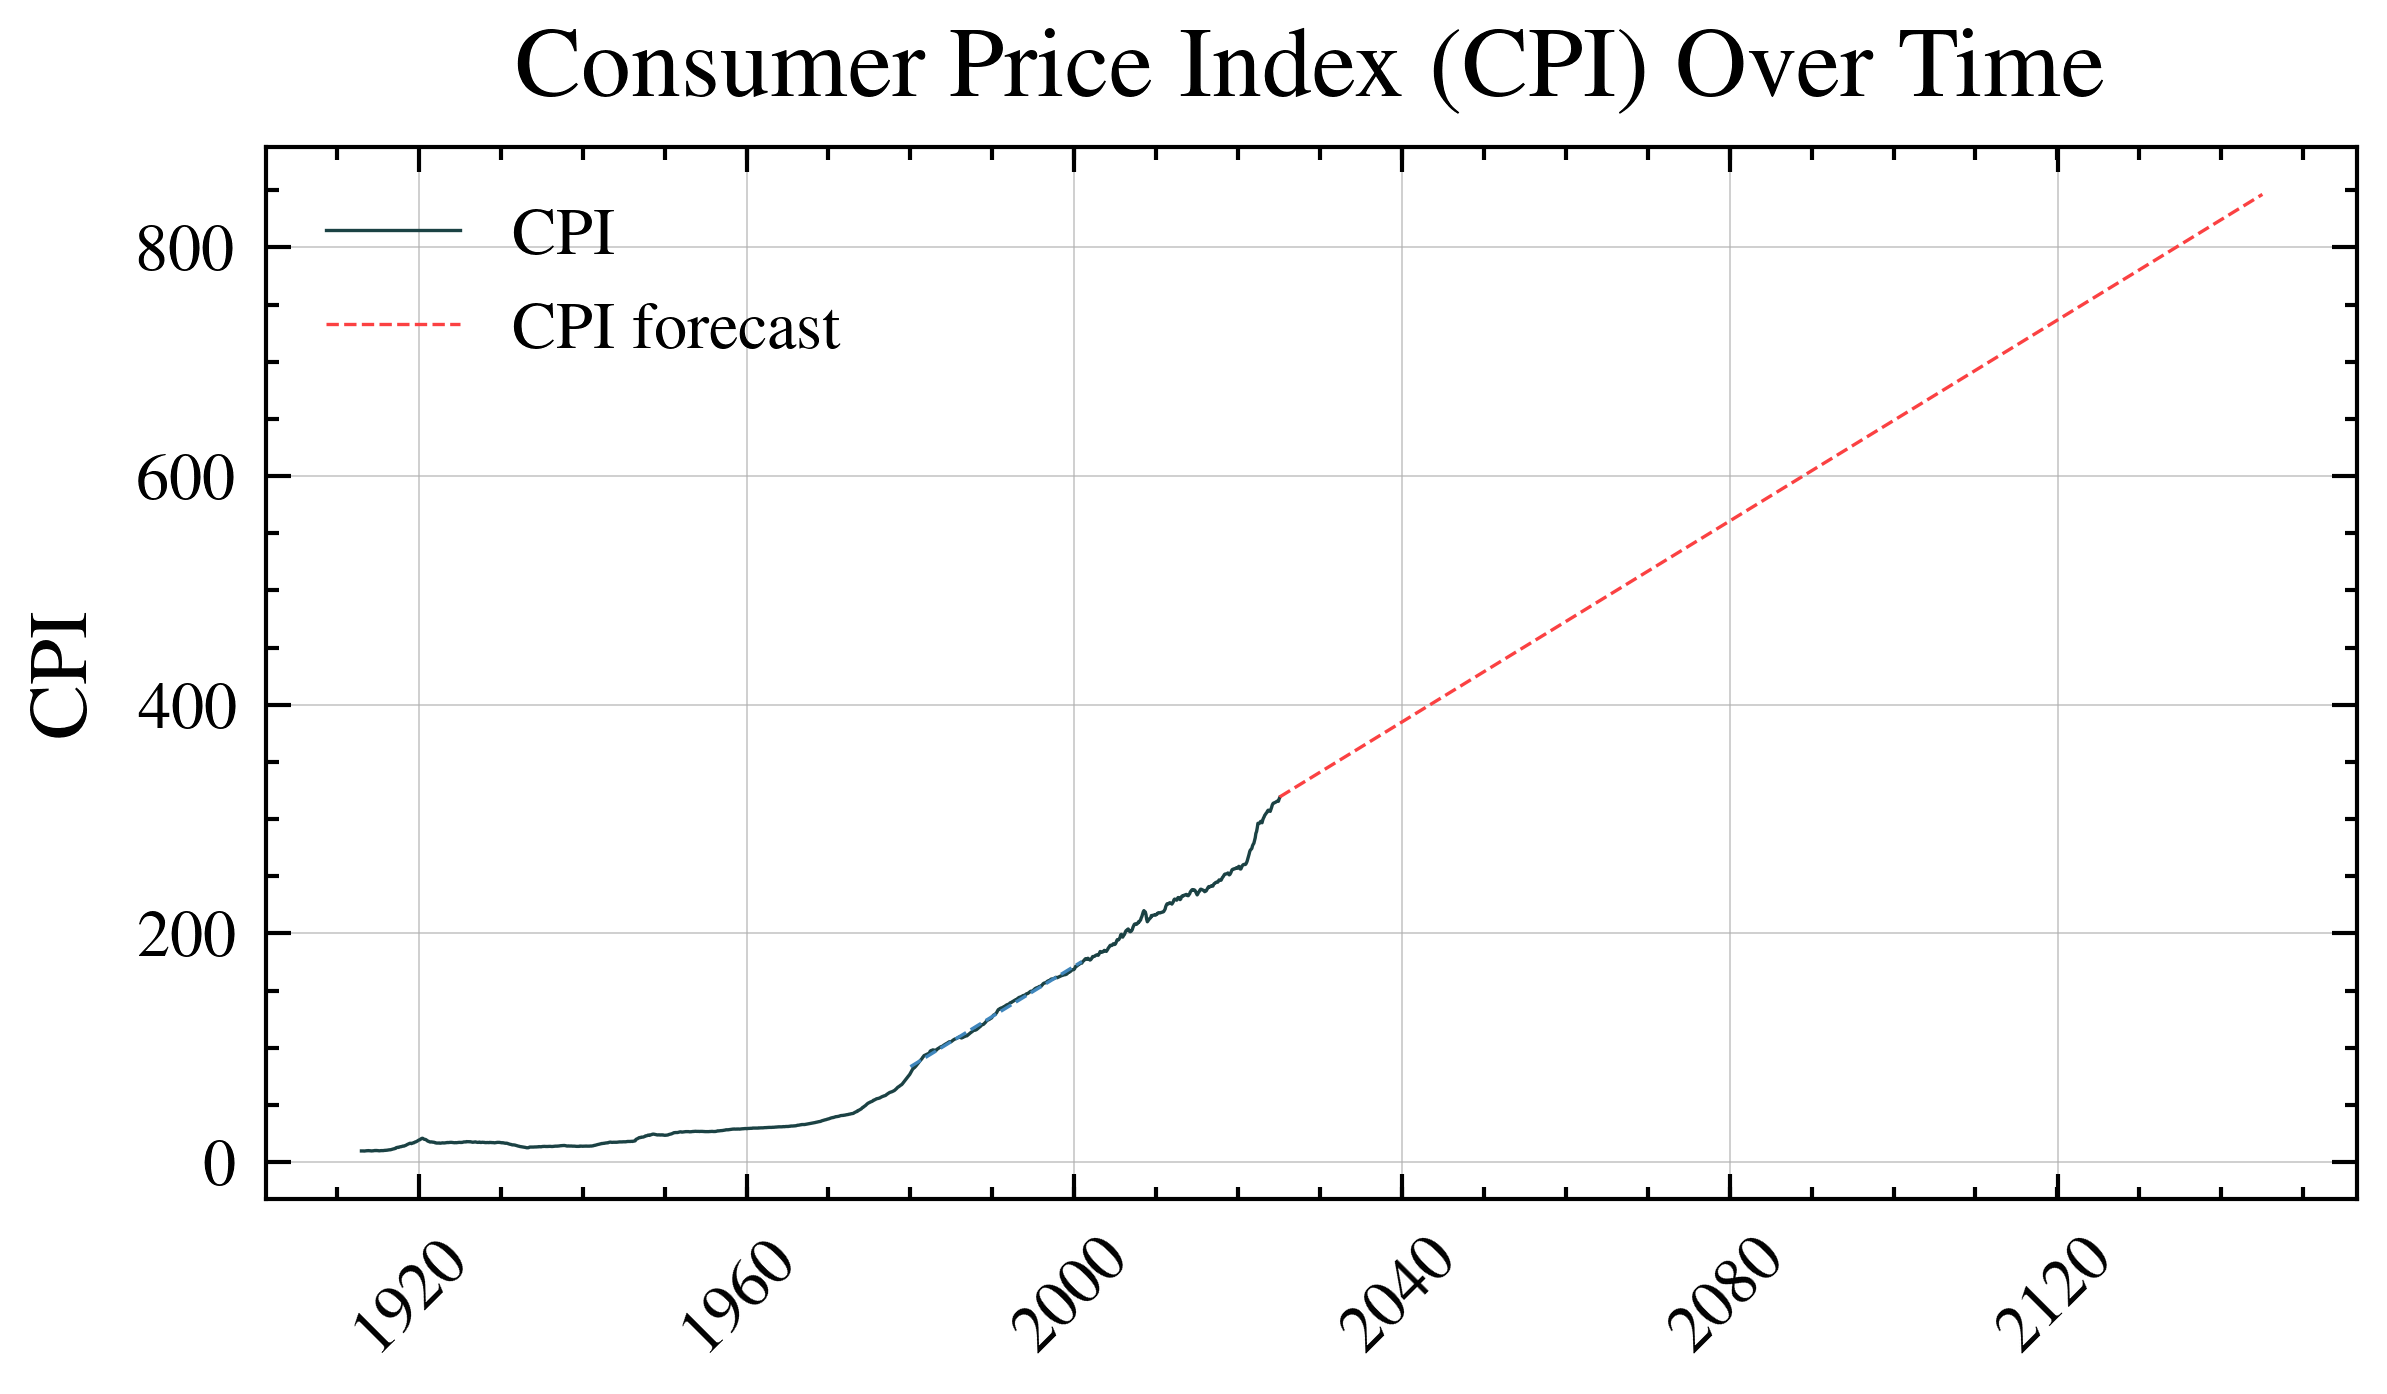

In [18]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(cpi_df[:df.index[-1]].index, cpi_df[:df.index[-1]]['CPI'], linewidth=0.4, linestyle='-', color=LINE_COLOR, label='CPI')
    plt.plot(cpi_df[df.index[-1]:].index, cpi_df[df.index[-1]:]['CPI'], linewidth=0.4, linestyle='--', color=LINE_COLOR_RED, label='CPI forecast')
    plt.plot(cpi_2020.index, regression_line, linewidth=0.4, linestyle='--', color=LINE_COLOR_BLUE)
    plt.ylabel('CPI', fontsize=10)
    plt.title('Consumer Price Index (CPI) Over Time', fontsize=12)
    plt.legend()
    plt.savefig(ASSETS+'cpiforecast1.png')
    plt.show()    


In [19]:
forecast_com.set_index('ds', inplace=True)
merged_com=pd.merge(forecast_com,cpi_df, left_index=True, right_index=True)
merged_com['v']=merged_com['yhat']*merged_com['CPI']

forecast_ind.set_index('ds', inplace=True)
merged_ind=pd.merge(forecast_ind,cpi_df, left_index=True, right_index=True)
merged_ind['v']=merged_ind['yhat']*merged_ind['CPI']

In [20]:
future_com = merged_com[mean_price_by_sector_month.index[-1]+pd.DateOffset(months=1):][['v','yhat','CPI']].rename(columns={'v': 'COM','yhat':'COM_CPI'})
future_ind = merged_ind[mean_price_by_sector_month.index[-1]+pd.DateOffset(months=1):][['v','yhat']].rename(columns={'v': 'IND','yhat':'IND_CPI'})

In [21]:
future = pd.merge(future_com,future_ind,left_index=True,right_index=True)

In [22]:
future_com

,COM,COM_CPI,CPI
2025-03-01,13.756270,0.043015,319.799000
2025-03-01,13.756270,0.043015,319.799000
2025-04-01,13.771895,0.043014,320.171890
2025-05-01,13.961784,0.043558,320.532751
2025-06-01,14.385234,0.044827,320.905641
...,...,...,...
2144-09-01,30.452088,0.036045,844.827886
2144-10-01,29.980342,0.035472,845.188747
2144-11-01,29.330023,0.034687,845.561637
2144-12-01,28.936220,0.034207,845.922498


In [23]:
# Append future data to mean_price_by_sector_month
mean_price_by_sector_month = pd.concat([mean_price_by_sector_month, future], axis=0)

In [24]:
mean_price_by_sector_month

,COM,IND,CPI,COM_CPI,IND_CPI
2001-01-01,7.199355,5.251129,175.100000,0.041116,0.029989
2001-02-01,7.401774,5.331935,175.800000,0.042103,0.030330
2001-03-01,7.530000,5.390484,176.200000,0.042736,0.030593
2001-04-01,7.591613,5.404355,176.900000,0.042915,0.030550
2001-05-01,7.684032,5.440161,177.700000,0.043242,0.030614
...,...,...,...,...,...
2144-09-01,30.452088,43.959155,844.827886,0.036045,0.052033
2144-10-01,29.980342,43.358885,845.188747,0.035472,0.051301
2144-11-01,29.330023,42.883731,845.561637,0.034687,0.050716
2144-12-01,28.936220,43.100089,845.922498,0.034207,0.050950


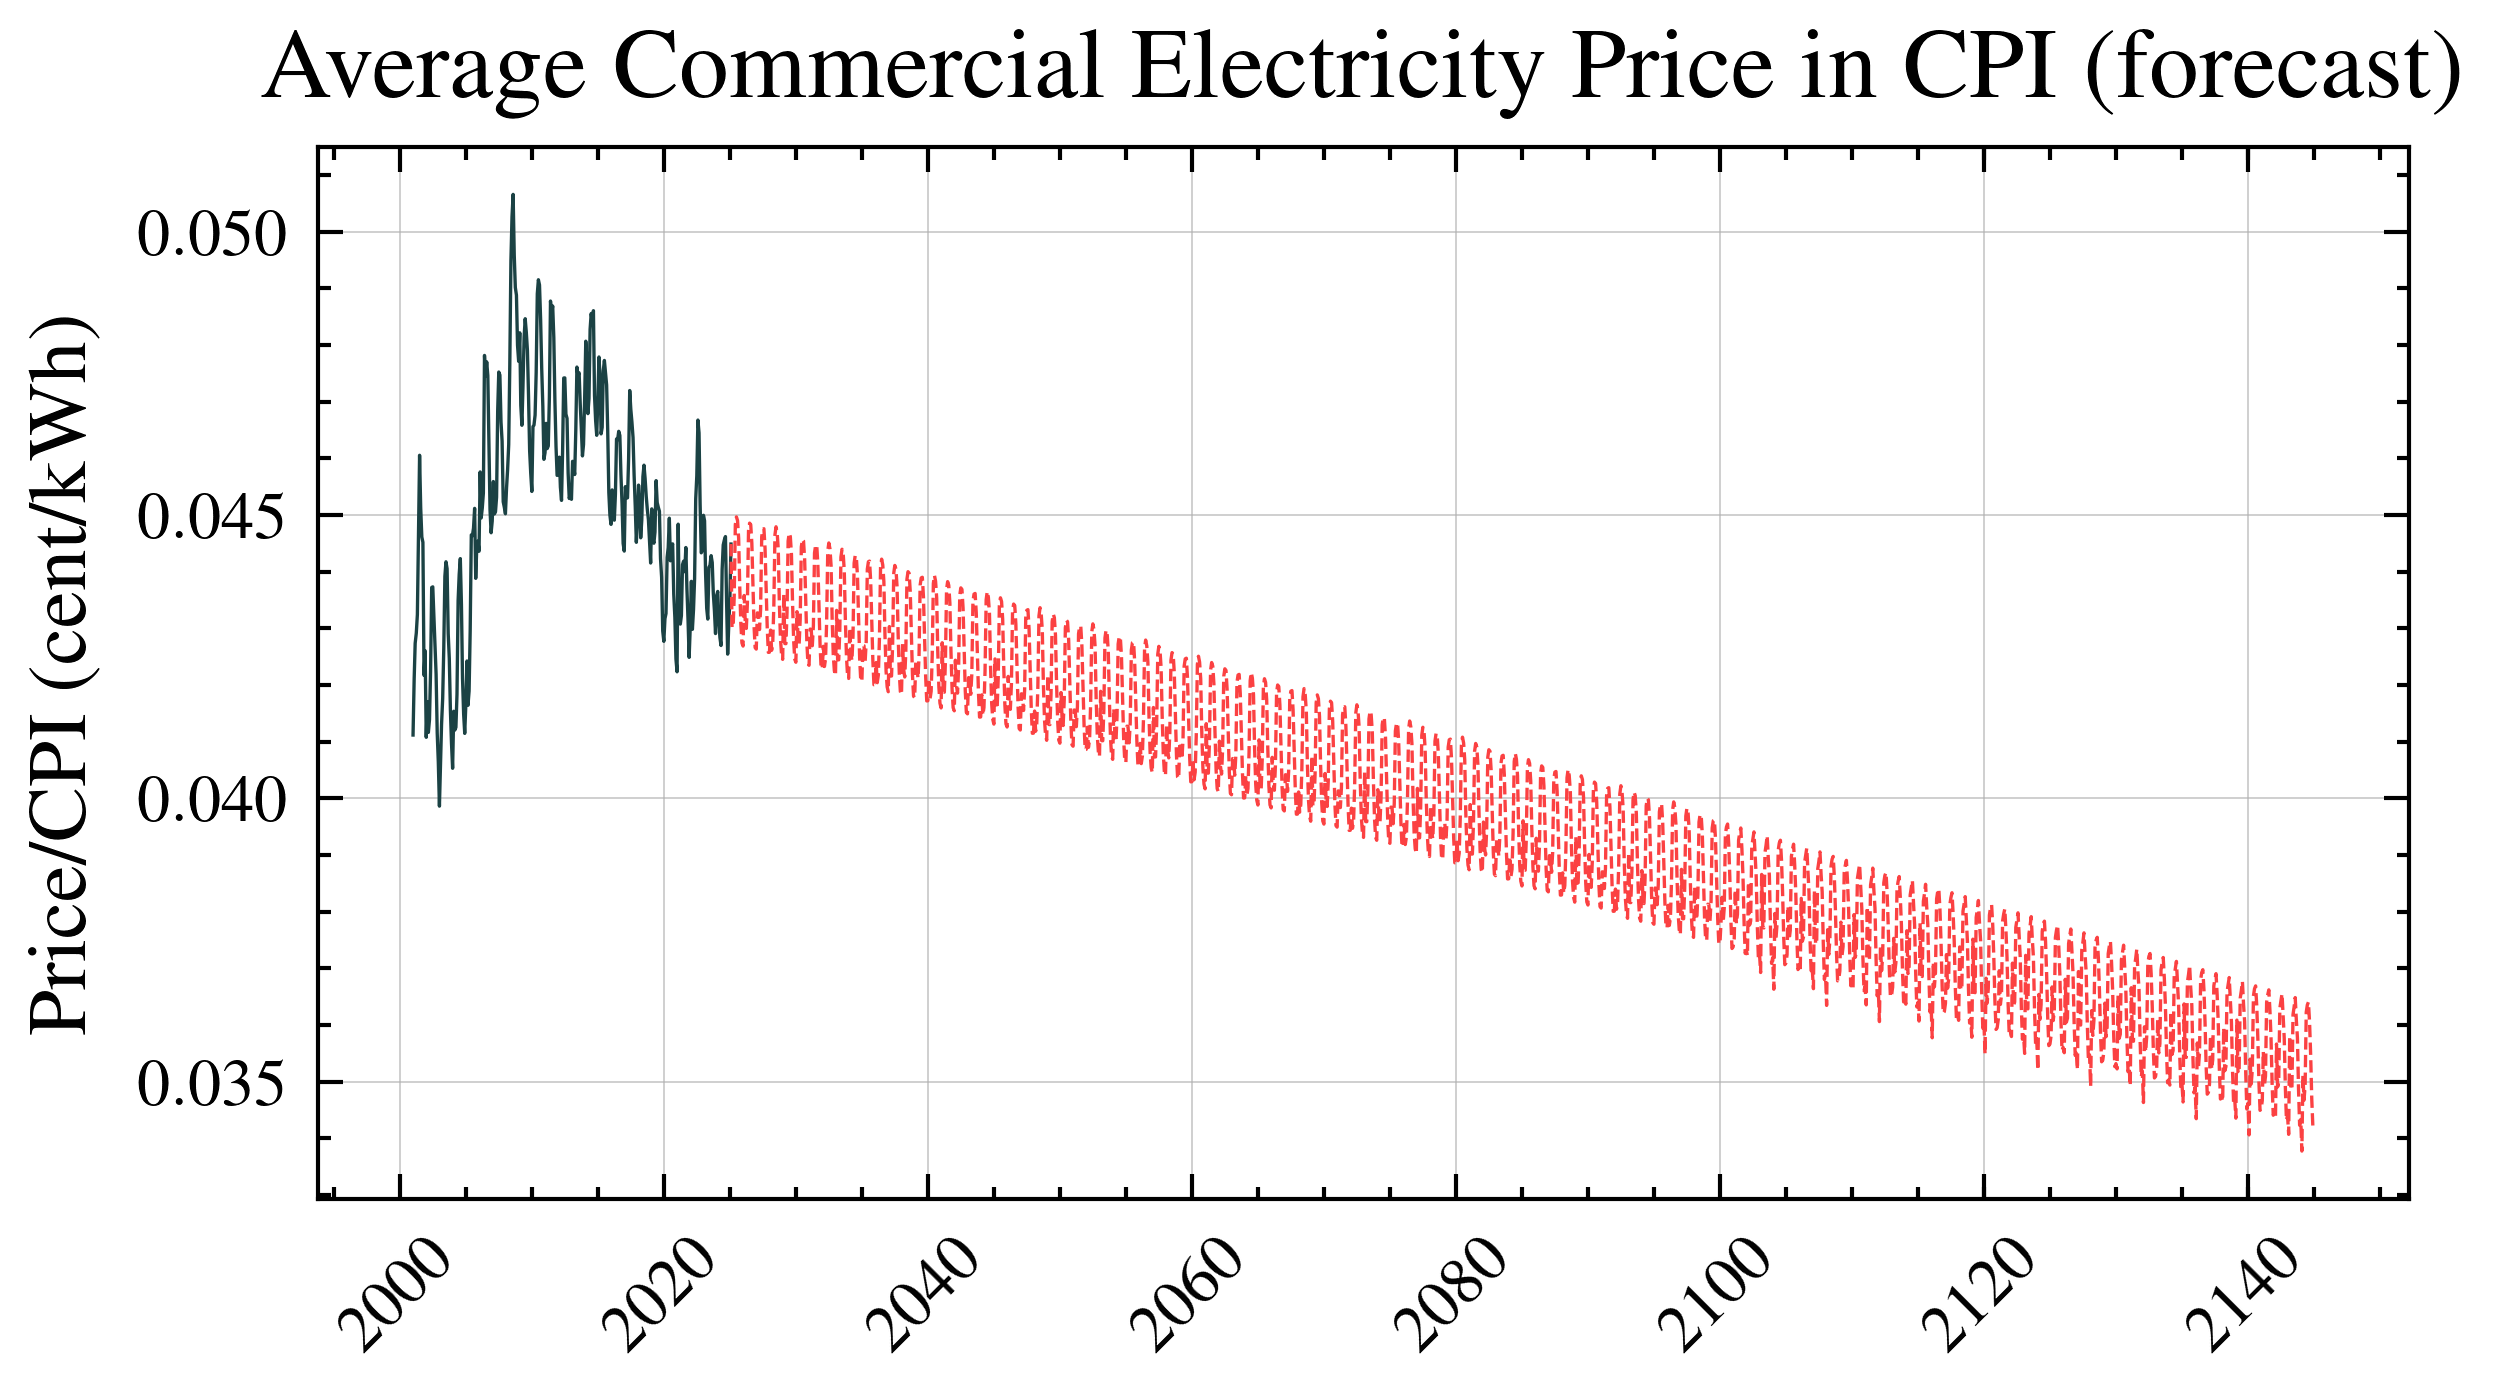

In [25]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(mean_price_by_sector_month[:df.index[-1]].index, mean_price_by_sector_month[:df.index[-1]]['COM_CPI'], linewidth=0.4, linestyle='-', color=LINE_COLOR)
    plt.plot(mean_price_by_sector_month[df.index[-1]:].index, mean_price_by_sector_month[df.index[-1]:]['COM_CPI'], linewidth=0.4, linestyle='--', color=LINE_COLOR_RED)
    plt.ylabel('Price/CPI (cent/kWh)', fontsize=10)
    plt.title('Average Commercial Electricity Price in CPI (forecast)', fontsize=12)
    plt.savefig(ASSETS+'electricitypricesforecast2.png')
    plt.show()    


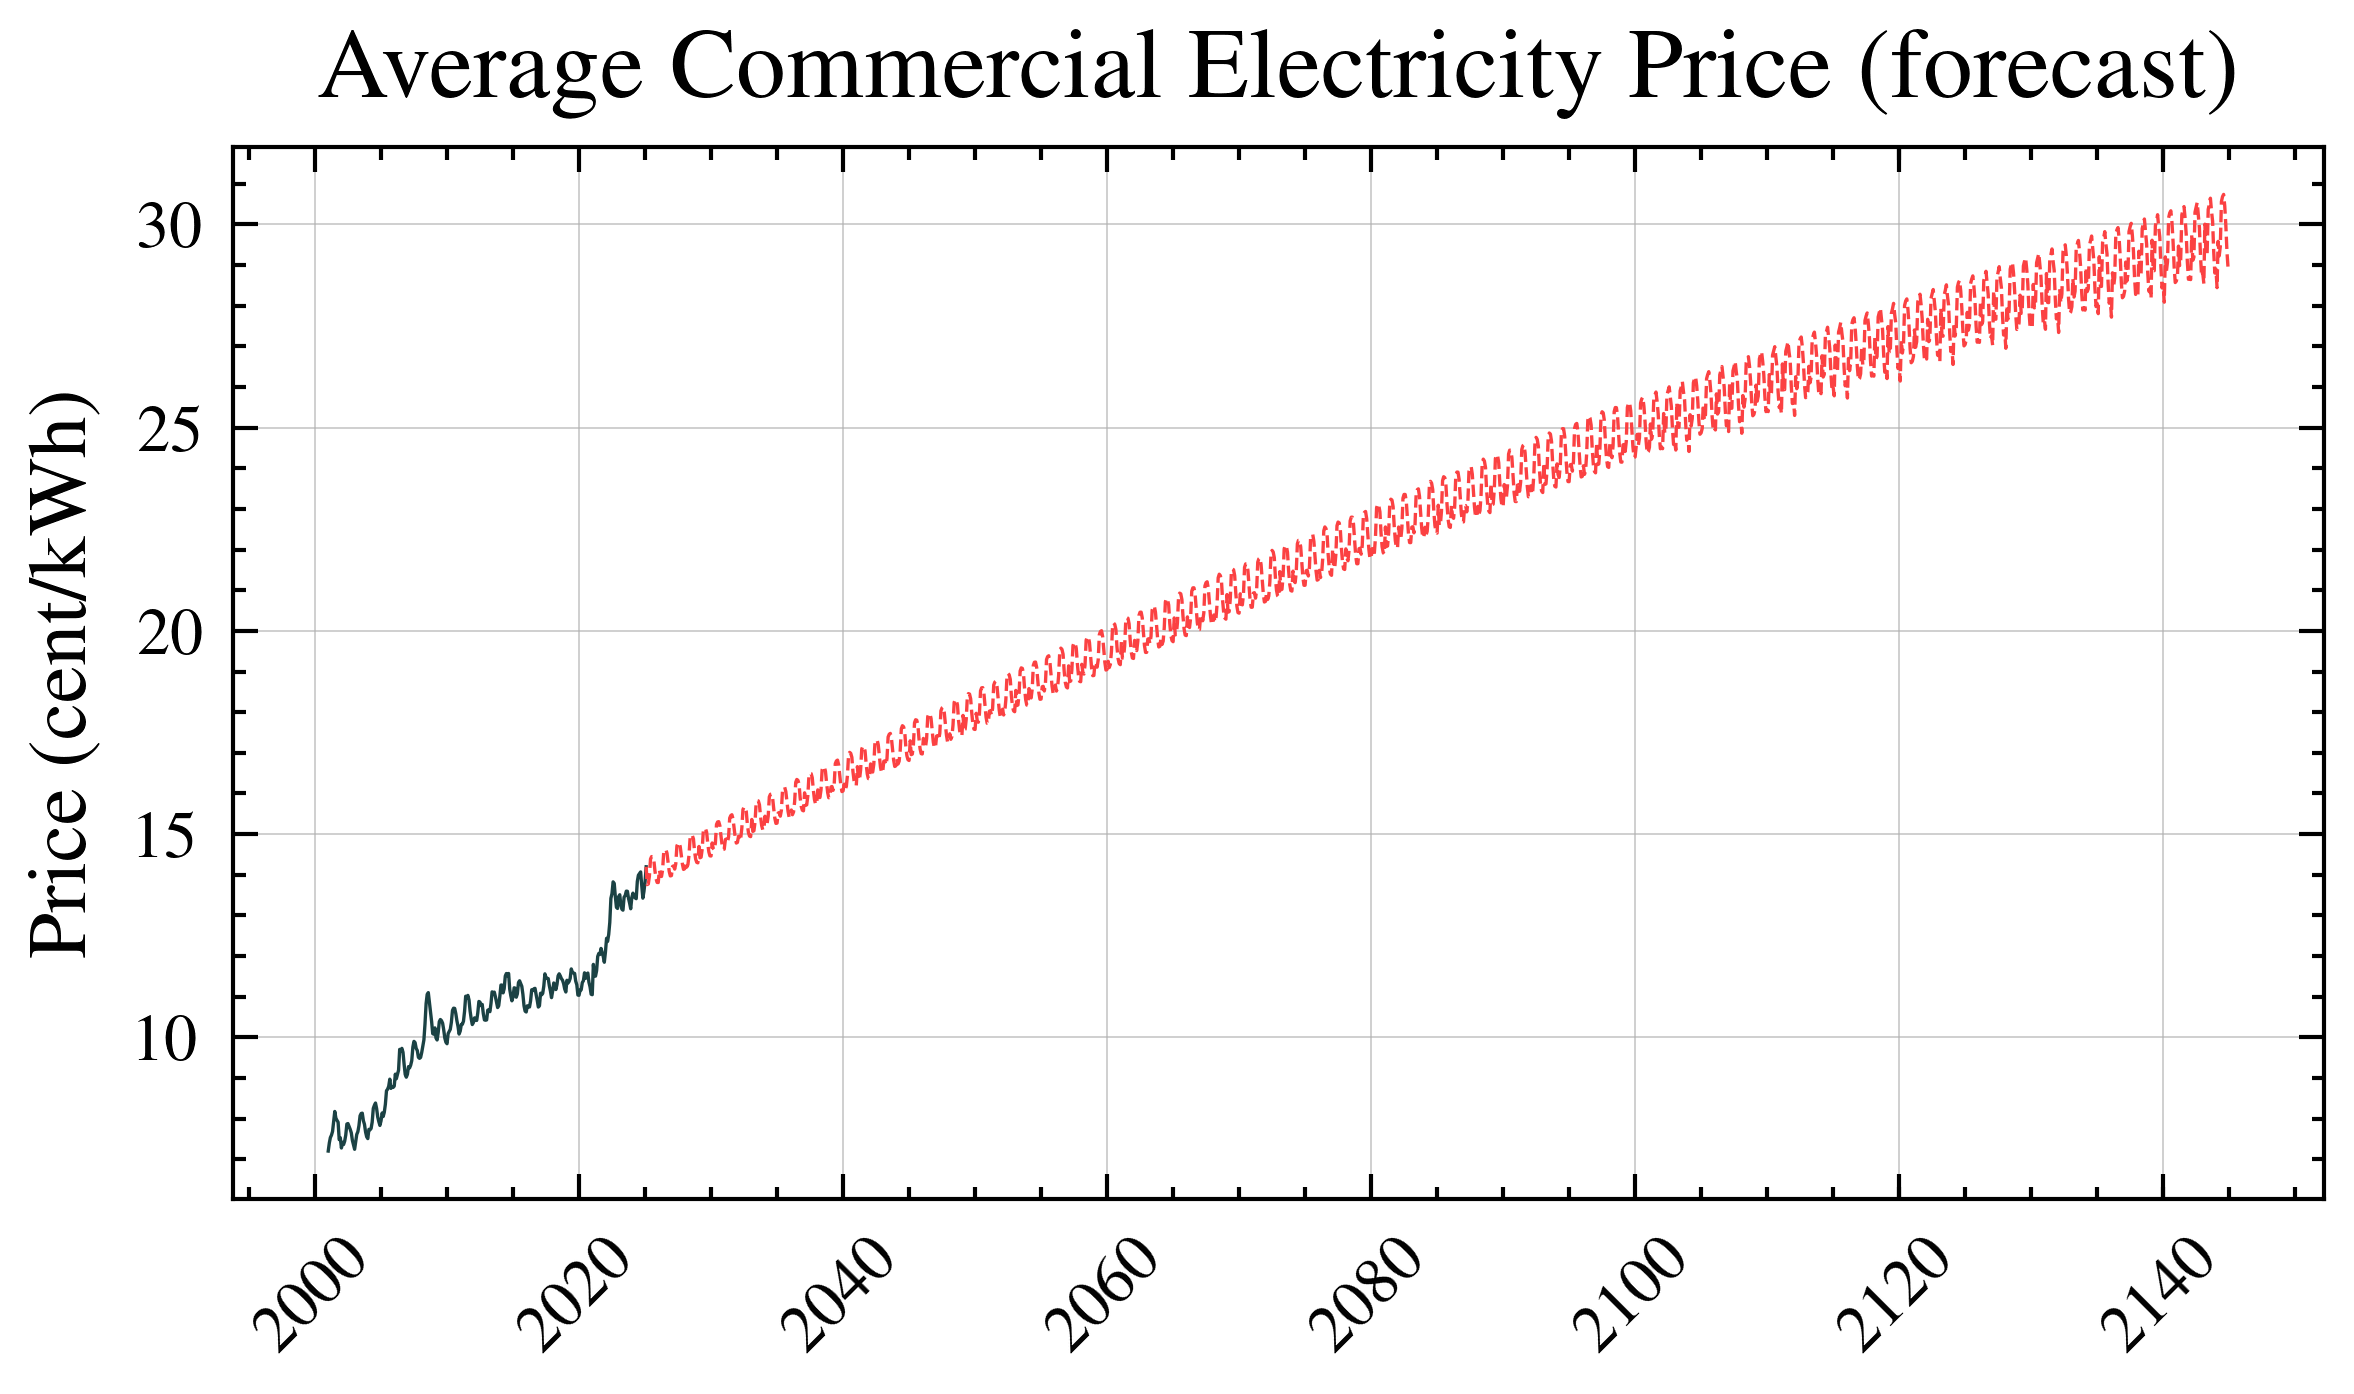

In [26]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(mean_price_by_sector_month[:df.index[-1]].index, mean_price_by_sector_month[:df.index[-1]]['COM'], linewidth=0.4, linestyle='-', color=LINE_COLOR)
    plt.plot(mean_price_by_sector_month[df.index[-1]:].index, mean_price_by_sector_month[df.index[-1]:]['COM'], linewidth=0.4, linestyle='--', color=LINE_COLOR_RED)
    plt.ylabel('Price (cent/kWh)', fontsize=10)
    plt.title('Average Commercial Electricity Price (forecast)', fontsize=12)
    plt.savefig(ASSETS+'electricitypricesforecast1.png')
    plt.show()    


In [27]:
mean_price_by_sector_month.to_csv(OUTPUT+'electricity_price.csv')